In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import logging
import argparse
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from itertools import product
from scipy.spatial import Delaunay

/home/ubuntu/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# truth PF

# Code

In [2]:
from tqdm import trange

In [3]:
import functions_hv_grad_3d

In [4]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv

In [5]:
import numpy as np
import torch

from functions_evaluation import fastNonDominatedSort
from functions_hv_grad_3d import grad_multi_sweep_with_duplicate_handling


class HvMaximization(object):
    """
    Mo optimizer for calculating dynamic weights using higamo style hv maximization
    based on Hao Wang et al.'s HIGA-MO
    uses non-dominated sorting to create multiple fronts, and maximize hypervolume of each
    """
    def __init__(self, n_mo_sol, n_mo_obj, ref_point, obj_space_normalize=True):
        super(HvMaximization, self).__init__()
        self.name = 'hv_maximization'
        self.ref_point = np.array(ref_point)
        self.n_mo_sol = n_mo_sol
        self.n_mo_obj = n_mo_obj
        self.obj_space_normalize = obj_space_normalize


    def compute_weights(self, mo_obj_val):
        n_mo_obj = self.n_mo_obj
        n_mo_sol = self.n_mo_sol

        # non-dom sorting to create multiple fronts
        hv_subfront_indices = fastNonDominatedSort(mo_obj_val)
        dyn_ref_point =  1.1 * np.max(mo_obj_val, axis=1)
        for i_obj in range(0,n_mo_obj):
            dyn_ref_point[i_obj] = np.maximum(self.ref_point[i_obj],dyn_ref_point[i_obj])
        number_of_fronts = np.max(hv_subfront_indices) + 1 # +1 because of 0 indexing
        
        obj_space_multifront_hv_gradient = np.zeros((n_mo_obj,n_mo_sol))
        for i_fronts in range(0,number_of_fronts):
            # compute HV gradients for current front
            temp_grad_array = grad_multi_sweep_with_duplicate_handling(mo_obj_val[:, (hv_subfront_indices == i_fronts) ],dyn_ref_point)
            obj_space_multifront_hv_gradient[:, (hv_subfront_indices == i_fronts) ] = temp_grad_array

        # normalize the hv_gradient in obj space (||dHV/dY|| == 1)
        normalized_obj_space_multifront_hv_gradient = np.zeros((n_mo_obj,n_mo_sol))
        for i_mo_sol in range(0,n_mo_sol):
            w = np.sqrt(np.sum(obj_space_multifront_hv_gradient[:,i_mo_sol]**2.0))
            if np.isclose(w,0):
                w = 1
            if self.obj_space_normalize:
                normalized_obj_space_multifront_hv_gradient[:,i_mo_sol] = obj_space_multifront_hv_gradient[:,i_mo_sol]/w
            else:
                normalized_obj_space_multifront_hv_gradient[:,i_mo_sol] = obj_space_multifront_hv_gradient[:,i_mo_sol]

        dynamic_weights = torch.tensor(normalized_obj_space_multifront_hv_gradient, dtype=torch.float)
        return(dynamic_weights)

In [6]:
def evenly_dist_weights(num_weights, dim):
    return [ret for ret in product(
        np.linspace(0.0, 1.0, num_weights), repeat=dim) if round(sum(ret), 3) == 1.0 and all(r not in (0.0, 1.0) for r in ret)]

In [7]:
class Toy_Hypernetwork(nn.Module):
  def __init__(self, ray_hidden_dim=30, out_dim=10, target_hidden_dim=15, n_hidden=1, n_tasks=3):
      super().__init__()
      self.n_hidden = n_hidden
      self.n_tasks = n_tasks

      self.ray_mlp = nn.Sequential(
            nn.Linear(3, ray_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(ray_hidden_dim, ray_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(ray_hidden_dim, ray_hidden_dim)
        )
      
      #self.hidden_0_weights = nn.Linear(ray_hidden_dim, target_hidden_dim)
      #self.hidden_0_bias = nn.Linear(ray_hidden_dim, target_hidden_dim)
      for j in range(n_tasks):
            setattr(self, f"task_{j}_weights", nn.Linear(ray_hidden_dim, out_dim))
            setattr(self, f"task_{j}_bias", nn.Linear(ray_hidden_dim, out_dim))

  def forward(self, ray):
      features = self.ray_mlp(ray)

      out_dict = {}
      #layer_types = ["hidden", "task"]
      layer_types = ["task"]
      for i in layer_types:
          if i == "hidden":
              n_layers = self.n_hidden
          elif i == "task":
              n_layers = self.n_tasks

          for j in range(n_layers):
              out_dict[f"{i}{j}.weights"] = getattr(self, f"{i}_{j}_weights")(features)
              out_dict[f"{i}{j}.bias"] = getattr(self, f"{i}_{j}_bias")(features).flatten()

      return out_dict

class Toy_Targetnetwork(nn.Module):
  def __init__(self, out_dim=10, target_hidden_dim=15, n_tasks=3):
      super().__init__()
      self.out_dim = out_dim
      self.n_tasks = n_tasks
      self.target_hidden_dim = target_hidden_dim

  def forward(self, weights=None):
    x = torch.ones([1, 1], dtype=torch.float32).to(device)
    #x = F.linear(x, weight=weights["hidden0.weights"].float().reshape(self.target_hidden_dim, x.shape[-1]), bias=weights["hidden0.bias"].float())
    outputs = []
    for j in range(self.n_tasks):
            outputs.append(
                F.sigmoid(F.linear(
                    x, weight=weights[f'task{j}.weights'].reshape(self.out_dim, x.shape[-1]),
                    bias=weights[f'task{j}.bias']
                ))
            )
    return outputs

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def toy_loss_1(output):
  return (torch.cos(np.pi/2*output[0, 0])*torch.cos(np.pi/2*output[0, 1])*(sum((output[0, 2:]-0.5)**2)+1))
def toy_loss_2(output):
  a = 1
  return (torch.cos(np.pi/2*output[0, 0]**a)*torch.sin(np.pi/2*output[0, 1]**a)*(sum((output[0, 2:]-0.5)**2)+1))
def toy_loss_3(output):
  a = 1
  return torch.sin(np.pi/2*output[0, 0]**a)*(sum((output[0, 2:]-0.5)**2)+1)

In [10]:
import random
def set_logger():
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO
    )


def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



In [11]:
set_logger()

In [12]:
class parse_arg():
  def __init__(self):
    pass
args = parse_arg()
args.no_cuda = False
args.gpus = '2'

In [13]:
def get_device(no_cuda=False, gpus='0'):
    return torch.device(f"cuda:{gpus}" if torch.cuda.is_available() and not no_cuda else "cpu")
device=get_device(no_cuda=args.no_cuda, gpus=args.gpus)
#device=get_device(no_cuda=True)

In [14]:
from functions_evaluation import fastNonDominatedSort

In [15]:
import copy
from functions_hv_python3 import HyperVolume

# Trainer

In [16]:
from pymoo.factory import get_reference_directions

In [17]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv

In [18]:
def train(device: torch.device, hidden_dim:int, lr: float, wd: float, epochs:int, alpha:float, head:int, 
          hesophat:float,cfg, partition):
  test_rays = get_reference_directions("das-dennis", 3, n_partitions=5).astype(
        np.float32
    )
  training = []

  hnet: nn.Module = Toy_Hypernetwork(ray_hidden_dim=hidden_dim, n_tasks=1)
  best_hv = 0
  net_list = []
  for i in range(head):
    net: nn.Module = Toy_Targetnetwork(n_tasks=1)
    net_list.append(net)
  logging.info(f"HN size: {count_parameters(hnet)}")

  hnet = hnet.to(device)
  for net in net_list:
    net = net.to(device)

  loss1 = toy_loss_1
  loss2 = toy_loss_2
  loss3 = toy_loss_3

  optimizer = torch.optim.Adam(hnet.parameters(), lr=lr, weight_decay=wd)

  ref_point = cfg["ref_point"]
  n_mo_sol = cfg["n_mo_sol"]
  n_mo_obj = cfg["n_mo_obj"]

  start = 0.
  end = np.pi/2
  print("Start Phase 1")
  phase1_iter = trange(10)

  optimizer_direction = torch.optim.Adam(hnet.parameters(), lr=5e-4, weight_decay=wd)
  for _ in phase1_iter:
    optimizer_direction.zero_grad()
    if (_+1) % 50 == 0:
      for param_group in optimizer.param_groups:
          param_group['lr'] *= np.sqrt(0.5)
      #patience = 0
      lr *= np.sqrt(0.5)    
    penalty_epoch = []

    losses_mean= []
    weights = []
    outputs = []
    rays = []
    penalty = []
    sum_penalty = 0
    for j in range(n_mo_sol):
      ray = np.random.dirichlet([1/3]*3, 1).astype(np.float32)

      ray = ray@test_rays[partition[j]]
      ray /= np.sum(ray)
      ray = ray.astype(np.float32)
      rays.append(torch.from_numpy(
                      ray.flatten()
                  ).to(device))           

      weights.append(hnet(rays[j]))
      outputs.append(net_list[j](weights[j])[0])
      losses_mean.append(torch.stack([loss1(outputs[j]), loss2(outputs[j]), loss3(outputs[j])]))

      penalty.append(torch.sum(losses_mean[j]*rays[j])/(torch.norm(rays[j])*torch.norm(losses_mean[j])))

      sum_penalty += penalty[j].item()

    direction_loss = 0.
    for phat in penalty[:]:
        direction_loss -= phat
    direction_loss.backward()
    optimizer_direction.step()

    aaa = sum_penalty/float(head)
    phase1_iter.set_description(f"Epochs {_} penalty {aaa:.2f}")

  print("End phase 1 after {}".format(_))
  mo_opt = HvMaximization(n_mo_sol, n_mo_obj, ref_point)
  
  dem = 0
  epoch_iter = trange(epochs)
  for epoch in epoch_iter:
    dem += 1
    hnet.train()
    optimizer.zero_grad()

    loss_torch_per_sample = []
    loss_numpy_per_sample = []
    loss_per_sample = []
    weights = []
    outputs = []
    rays = []
    penalty = []
    for i in range(n_mo_sol):
      random = np.random.uniform(start, end)

      ray = np.random.dirichlet([1/3]*3, 1).astype(np.float32)
      ray = ray@test_rays[partition[i]]

      ray /= np.sum(ray)
      ray = ray.astype(np.float32)
      rays.append(torch.from_numpy(
                      ray.flatten()).to(device))

      weights.append(hnet(rays[i]))

      outputs.append(net_list[i](weights[i])[0])
      
      loss_per_sample = torch.stack([loss1(outputs[i]), loss2(outputs[i]), loss3(outputs[i])])

      loss_torch_per_sample.append(loss_per_sample)
      loss_numpy_per_sample.append(loss_per_sample.cpu().detach().numpy())

      penalty.append(torch.sum(loss_torch_per_sample[i]*rays[i])/
                     (torch.norm(loss_torch_per_sample[i])*torch.norm(rays[i])))

    loss_numpy_per_sample = np.array(loss_numpy_per_sample)[np.newaxis, :, :].transpose(0, 2, 1) 

    n_samples = 1
    dynamic_weights_per_sample = torch.ones(n_mo_sol, n_mo_obj, n_samples)
    for i_sample in range(0, n_samples):
      weights_task = mo_opt.compute_weights(loss_numpy_per_sample[i_sample,:,:])
      dynamic_weights_per_sample[:, :, i_sample] = weights_task.permute(1,0)
      
    dynamic_weights_per_sample = dynamic_weights_per_sample.to(device)
    i_mo_sol = 0
    total_dynamic_loss = torch.mean(torch.sum(dynamic_weights_per_sample[i_mo_sol, :, :]
                                              * loss_torch_per_sample[i_mo_sol], dim=0))
    for i_mo_sol in range(1, len(net_list)):
      total_dynamic_loss += torch.mean(torch.sum(dynamic_weights_per_sample[i_mo_sol, :, :] 
                                          * loss_torch_per_sample[i_mo_sol], dim=0))
    
    for idx in range(head):
      total_dynamic_loss -= hesophat*penalty[idx]
    
      
    total_dynamic_loss /= head
    total_dynamic_loss.backward()
    optimizer.step()

    penalty = [i.item() for i in penalty]

    if epoch % 300 ==0:
      training.append([i.detach().cpu().tolist() for i in loss_torch_per_sample])
  return hnet, net, training, partition

# Test

In [19]:
unit = np.linspace(0, 1, 6)
n_tasks = 3
vector = [0]*n_tasks
rays_vector = []
rays_vector = get_reference_directions("das-dennis", 3, n_partitions=5).astype(
        np.float32
    )

rays_sampling = np.array(rays_vector)
rays_vector_2 = np.delete(rays_sampling, -1, axis=1)
tri = Delaunay(rays_vector_2)
partition = tri.simplices
partition = partition.astype(np.int32)

In [22]:
cfg = {}
cfg["ref_point"] = (2, 2, 2)
cfg["n_mo_obj"] = 3
cfg["n_mo_sol"] = partition.shape[0]
device = get_device(no_cuda=args.no_cuda, gpus=args.gpus)
hidden_dim=100
lr=1e-3
wd=0.
epochs=10000
alpha=1.
cfg= cfg
head=cfg["n_mo_sol"]
hesophat=100. #lamda
n_mo_obj = cfg["n_mo_obj"]
n_mo_sol = cfg["n_mo_sol"]
ref_point = cfg["ref_point"]
method = "4_MH"

In [23]:
hnet, net, training, partition = train(device = get_device(no_cuda=args.no_cuda, gpus=args.gpus), hidden_dim=100,
                  lr=1e-3, wd=0., epochs=epochs, alpha=0.2, cfg= cfg, head=cfg['n_mo_sol'], hesophat=hesophat, partition=partition);

2022-12-15 16:23:04,568 - root - INFO - HN size: 22620


Start Phase 1


Epochs 9 penalty 0.83: 100%|██████████| 10/10 [00:00<00:00, 10.28it/s]


End phase 1 after 9


100%|██████████| 10000/10000 [20:56<00:00,  7.96it/s]


In [24]:
results = []
loss1 = toy_loss_1
loss2 = toy_loss_2
loss3 = toy_loss_3

rays = get_reference_directions("das-dennis", 3, n_partitions=20).astype(
        np.float32
    )

for i in range(len(rays)):
  ray = rays[i]
  
  ray /= ray.sum()
  ray = ray.astype(np.float32)   
  ray = torch.from_numpy(
                      ray.flatten()
                  ).to(device)

  weights = hnet(ray)
  output = net(weights)[0]
  l1 = loss1(output)
  l2 = loss2(output)
  l3 = loss3(output)
  results.append([l1, l2, l3])

In [25]:
results = [[i[0].cpu().detach().numpy(), i[1].cpu().detach().numpy(), i[2].cpu().detach().numpy()] for i in results]
results = np.array(results, dtype='float32')


In [26]:
import matplotlib.collections
import mpl_toolkits.mplot3d as a3
import matplotlib as mpl
import scipy as sp

/tmp/ipykernel_150525/480779016.py:10: DeprecationWarning: scipy.rand is deprecated and will be removed in SciPy 2.0.0, use numpy.random.rand instead
  face.set_color(mpl.colors.rgb2hex(sp.rand(3)))


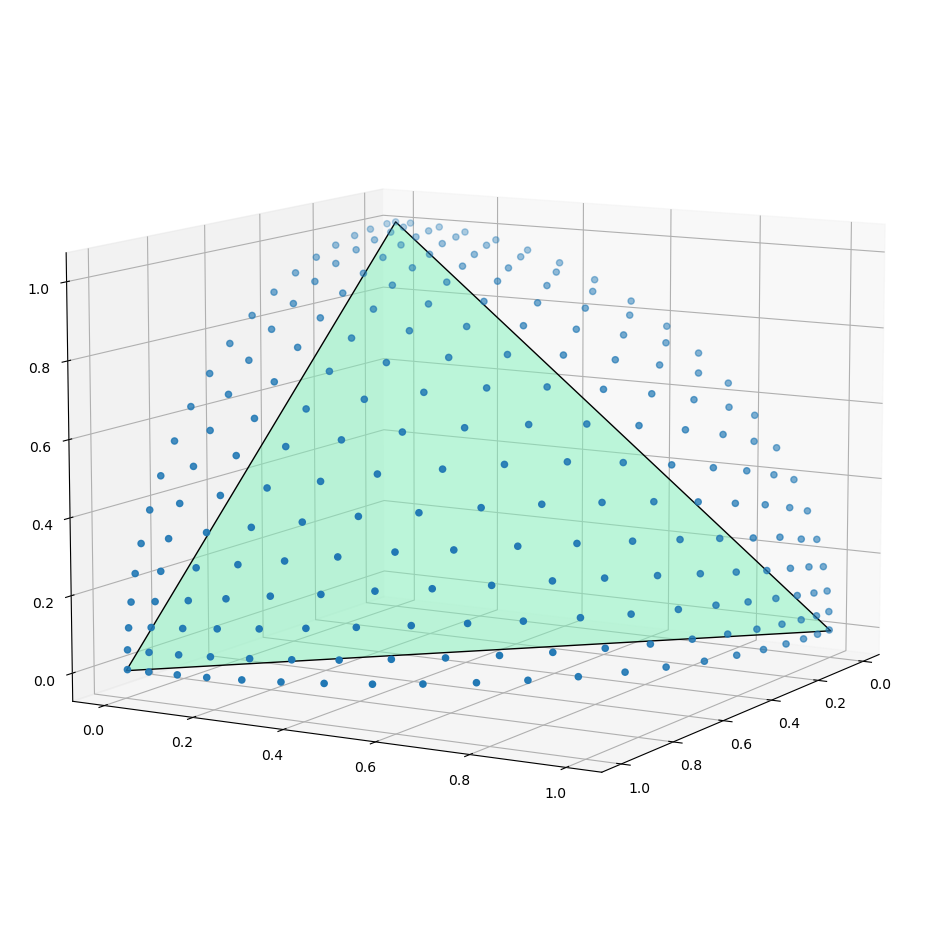

In [27]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
#ax.dist = 30
ax.azim = 60
f = [[1, 0., 0. ],
       [0., 0, 1.],
       [0., 1., 0. ]]
f = np.array(f)
face = a3.art3d.Poly3DCollection([f])
face.set_color(mpl.colors.rgb2hex(sp.rand(3)))
face.set_edgecolor('k')
face.set_alpha(0.5)
ax.add_collection3d(face)
#plt.show()

#fig = plt.figure(figsize=(12, 12))
#ax = fig.add_subplot(projection='3d')
ax.scatter(results[:, 0], results[:, 1], results[:, 2])
#ax.scatter(rays[:, 0], rays[:, 1], rays[:, 2], color='r')
ax.view_init(elev=10., azim=30)

In [32]:
# np.save("front/Toy_"+method+".npy", results)